In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics


In [4]:
# change the path to where your CSV is saved
df = pd.read_csv("insurance.csv")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [5]:
df.info()
df.describe()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

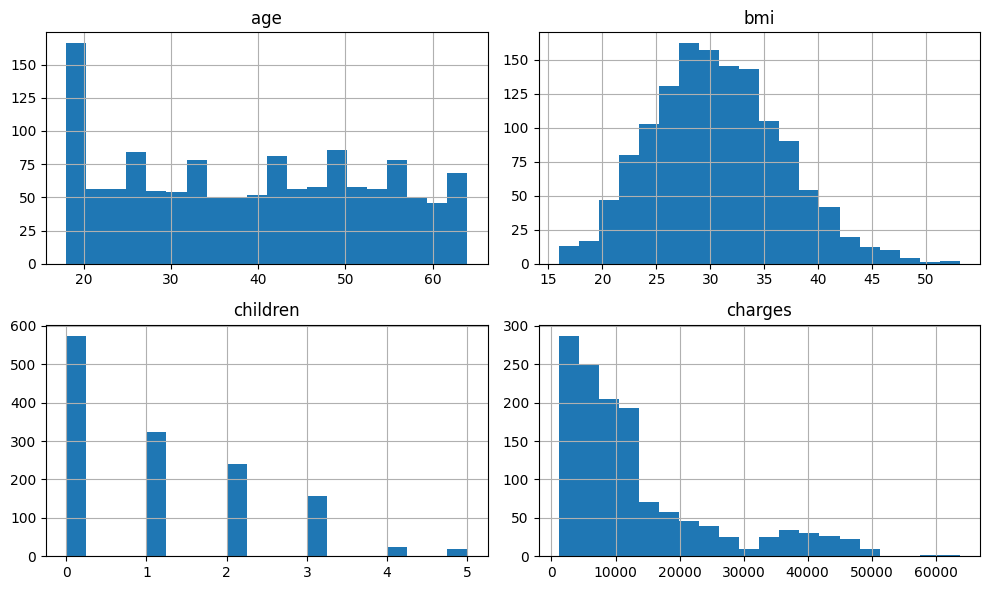

In [7]:
num_cols = ["age", "bmi", "children", "charges"]

df[num_cols].hist(bins=20, figsize=(10,6))
plt.tight_layout()
plt.show()


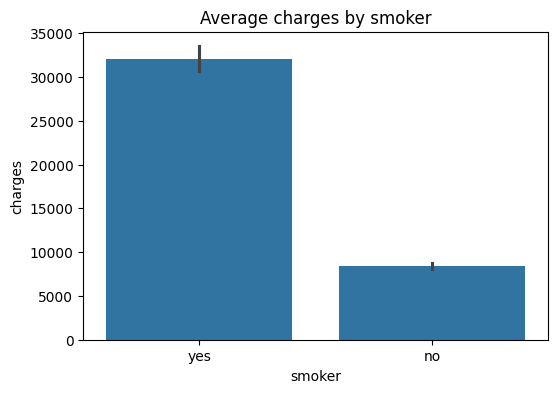

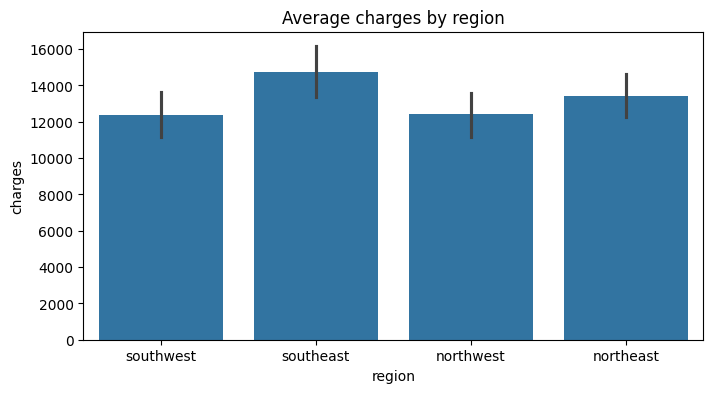

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="smoker", y="charges")
plt.title("Average charges by smoker")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=df, x="region", y="charges")
plt.title("Average charges by region")
plt.show()


In [13]:
X = df.drop(columns=["charges"])
y = df["charges"]

X = pd.get_dummies(X, drop_first=True)
X.head(10)


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False
5,31,25.740,0,False,False,False,True,False
6,46,33.440,1,False,False,False,True,False
7,37,27.740,3,False,False,True,False,False
8,37,29.830,2,True,False,False,False,False
9,60,25.840,0,False,False,True,False,False


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((1070, 8), (268, 8))

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [15]:
k_values = [3, 5, 7, 9, 11]
cv_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(
        knn, X_train_scaled, y_train,
        cv=5, scoring="neg_mean_squared_error"
    )
    cv_scores.append(-scores.mean())
    print(f"k={k}, CV MSE={-scores.mean()}")

k=3, CV MSE=34043704.10909747
k=5, CV MSE=32502955.75033044
k=7, CV MSE=33022485.694918822
k=9, CV MSE=32165713.868579578
k=11, CV MSE=32871117.048205674


In [16]:
# pick best k
best_k = k_values[int(np.argmin(cv_scores))]
print("Best k:", best_k)

# train final KNN
knn_final = KNeighborsRegressor(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

y_pred_knn = knn_final.predict(X_test_scaled)

mse_knn  = metrics.mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn  = metrics.mean_absolute_error(y_test, y_pred_knn)
r2_knn   = metrics.r2_score(y_test, y_pred_knn)

print("KNN Regression")
print("MSE :", mse_knn)
print("RMSE:", rmse_knn)
print("MAE :", mae_knn)
print("R^2 :", r2_knn)


Best k: 9
KNN Regression
MSE : 31296361.313667413
RMSE: 5594.315088879729
MAE : 3470.612809896766
R^2 : 0.7984114845065527


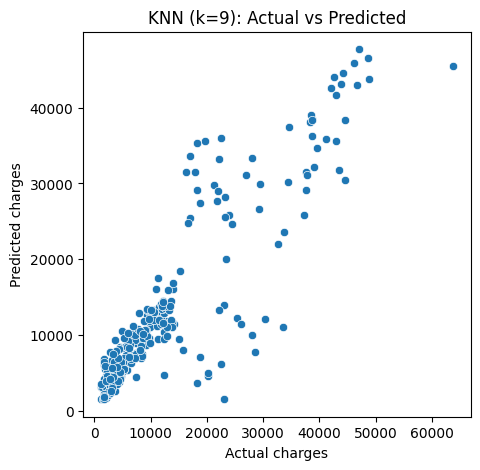

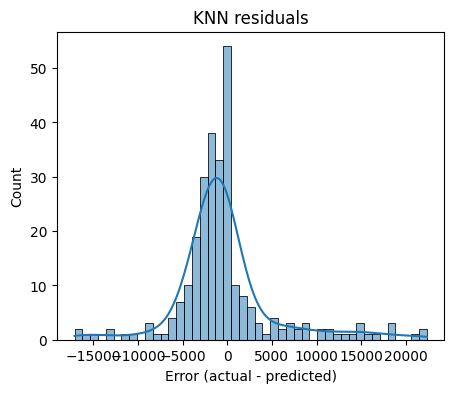

In [17]:
# KNN plots
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred_knn)
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title(f"KNN (k={best_k}): Actual vs Predicted")
plt.show()

residuals_knn = y_test - y_pred_knn
plt.figure(figsize=(5,4))
sns.histplot(residuals_knn, kde=True)
plt.title("KNN residuals")
plt.xlabel("Error (actual - predicted)")
plt.show()


In [18]:
# metrics table
results = pd.DataFrame({
    "Model": ["Linear Regression", "KNN"],
    "MSE":  [mse_lr, mse_knn],
    "RMSE": [rmse_lr, rmse_knn],
    "MAE":  [mae_lr, mae_knn],
    "R2":   [r2_lr, r2_knn]
})
results


,Model,MSE,RMSE,MAE,R2
0,Linear Regression,3.359692e+07,5796.284659,4181.194474,0.783593
1,KNN,3.129636e+07,5594.315089,3470.612810,0.798411
